### Overview: Magnetar

In [1]:
# notebook configuration
%config InlineBackend.figure_formats = ['svg']

# package import
import astropy.constants  as const
import astropy.units      as u
import matplotlib         as mpl
import matplotlib.pyplot  as plt
import numpy              as np
import scipy.integrate    as integ

# figure setting
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color = ['olivedrab', 'steelblue', 'firebrick', 'goldenrod'])
plt.rcParams['figure.figsize']                 = [8,5]
plt.rcParams['figure.constrained_layout.use']  = True
plt.rcParams['legend.frameon']                 = False
plt.rcParams["xtick.minor.visible"]            = True
plt.rcParams["ytick.minor.visible"]            = True

# shorthand assignment
arr = np.array

# natural constants
c     = const.c
e     = const.e
mu0   = const.mu0
eps0  = const.eps0

# conversion helper
k = 4 * np.pi / mu0
r = np.sqrt(mu0 / eps0)

In [2]:
# magnetar class
class magnetar:
    # constructor defaults declaration
    def __init__(self, B = 1e+15 * u.G, R = 1e+6 * u.cm, M = 2.8e+33 * u.g, P = 6.3e-4 * u.s, chi = 54.7 * u.deg):
        self.B    = B    # magnetic flux density
        self.R    = R    # sphere radius
        self.M    = M    # total mass
        self.P    = P    # initial spin period
        self.chi  = chi  # dipole rotation axis tilt angle
        self.set_vals()

    # derived quantities
    def set_vals(self):
        self.O    = 2 * np.pi / self.P                                             # initial angular frequency
        self.mu   = k * self.B * self.R**3 / 2                                     # dipole moment
        self.lum  = self.mu**2 * self.O**4 / c**3 / k * (1 + np.sin(self.chi)**2)  # initial luminosity
        self.I    = 2 / 5 * self.M * self.R**2                                     # classical inertia moment
        self.tsd  = 1 / 2 * self.I * self.O**2 / self.lum                          # spindown time

    # time scaling factor
    def scale_t(self, t):
        return 1 / (1 + t / self.tsd.to('s').value)

    # parametrized functions
    def L(self, t):
        return self.lum * self.scale_t(t)**2
    def E_M(self, t, facc = 1e-1):
        return r * facc * e.si * self.mu * self.O**2 / c**2 * self.scale_t(t)
    def dN_dE_dt_p(self, t):
        return self.B * self.R**3 * self.O**2 / e.si / c / r / u.GeV * self.scale_t(t)

In [3]:
# object initialization
default_mag = magnetar()
parallel_mag = magnetar(1e+14 * u.G, 1e+4 * u.m, 2 * u.solMass, 6.3e-3 * u.s, 0 * u.deg)
perpendicular_mag = magnetar(1e+14 * u.G, 1e+4 * u.m, 2 * u.solMass, 6.3e-3 * u.s, 90 * u.deg)

# printing derived quantities
print('Default:')
print(f'lum = {default_mag.lum.to(u.erg / u.s):.2}')
print(f'tsd = {default_mag.tsd.to(u.s):.2}')
print(f'E_M = {default_mag.E_M(0).to(u.GeV):.2}')
print(f'dN_dE_dt = {default_mag.dN_dE_dt_p(0).to(1 / u.s / u.GeV):.2}')
print()
print('Parallel:')
print(f'lum = {parallel_mag.lum.to(u.erg / u.s):.2}')
print(f'tsd = {parallel_mag.tsd.to(u.s):.2}')
print(f'E_M = {parallel_mag.E_M(0).to(u.GeV):.2}')
print(f'dN_dE_dt = {parallel_mag.dN_dE_dt_p(0).to(1 / u.s / u.GeV):.2}')
print()
print('Perpendicular:')
print(f'lum = {perpendicular_mag.lum.to(u.erg / u.s):.2}')
print(f'tsd = {perpendicular_mag.tsd.to(u.s):.2}')
print(f'E_M = {perpendicular_mag.E_M(0).to(u.GeV):.2}')
print(f'dN_dE_dt = {perpendicular_mag.dN_dE_dt_p(0).to(1 / u.s / u.GeV):.2}')

# calculating time integration
t = np.logspace(0, 9, 3*10**6)

default_Ep = default_mag.E_M(t).to(u.GeV).value
default_dNdEdt = default_mag.dN_dE_dt_p(t).to(1 / u.GeV / u.s).value
default_dNdE = np.cumsum(default_dNdEdt[1:] * (t[1:] - t[:-1]))

parallel_Ep = parallel_mag.E_M(t).to(u.GeV).value
parallel_dNdEdt = parallel_mag.dN_dE_dt_p(t).to(1 / u.GeV / u.s).value
parallel_dNdE = np.cumsum(parallel_dNdEdt[1:] * (t[1:] - t[:-1]))

perpendicular_Ep = perpendicular_mag.E_M(t).to(u.GeV).value
perpendicular_dNdEdt = perpendicular_mag.dN_dE_dt_p(t).to(1 / u.GeV / u.s).value
perpendicular_dNdE = np.cumsum(perpendicular_dNdEdt[1:] * (t[1:] - t[:-1]))

Default:
lum = 1.5e+50 erg / s
tsd = 3.6e+02 s
E_M = 2.1e+13 GeV
dN_dE_dt = 5.5e+38 1 / (GeV s)

Parallel:
lum = 9.2e+43 erg / s
tsd = 8.6e+06 s
E_M = 2.1e+10 GeV
dN_dE_dt = 5.5e+35 1 / (GeV s)

Perpendicular:
lum = 1.8e+44 erg / s
tsd = 4.3e+06 s
E_M = 2.1e+10 GeV
dN_dE_dt = 5.5e+35 1 / (GeV s)


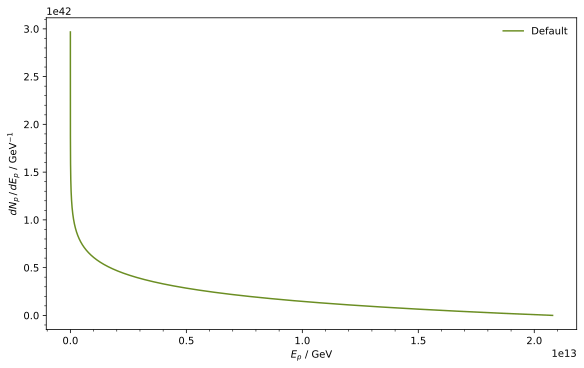

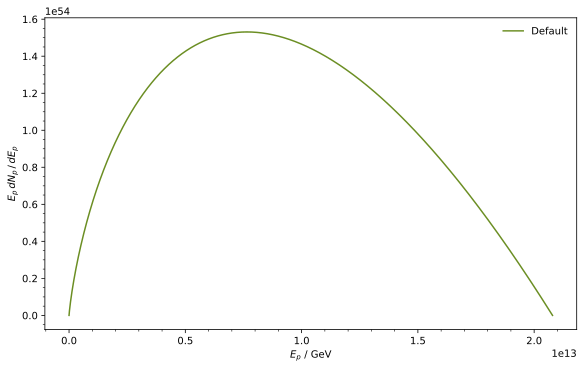

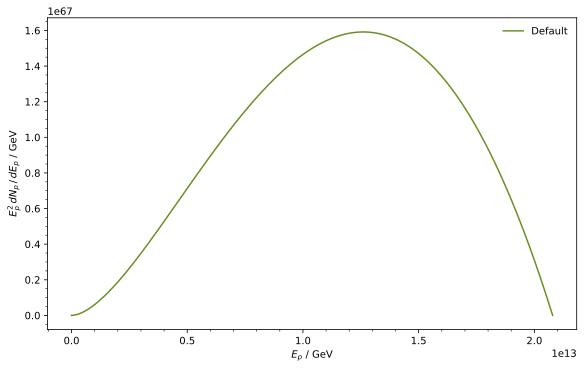

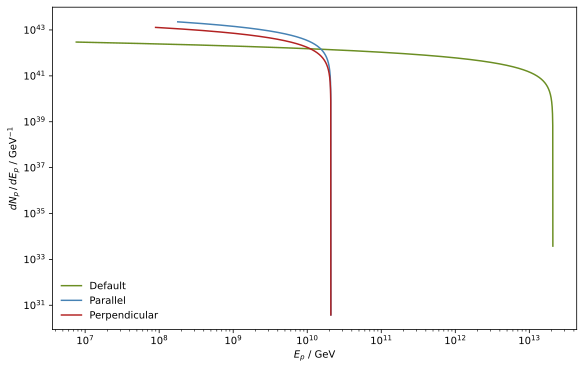

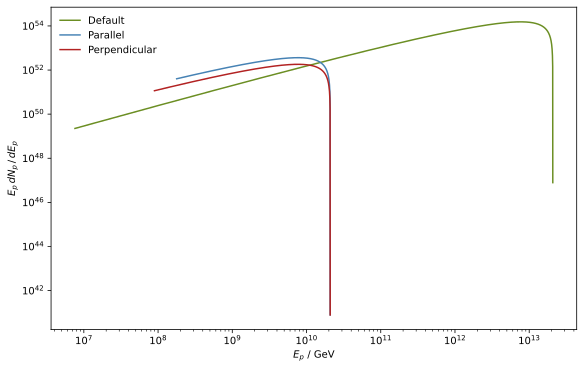

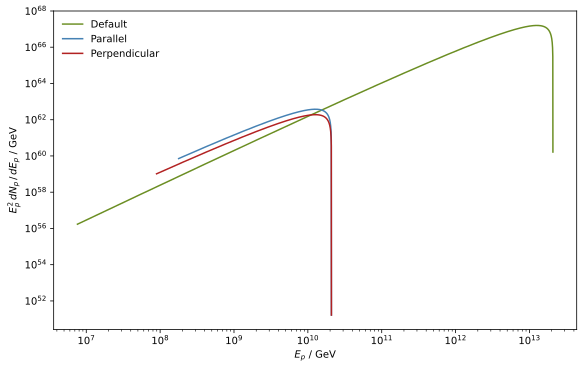

In [4]:
# plotting linear results
plt.plot(default_Ep[1:], default_dNdE, label='Default')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$dN_p\,/\,dE_p$ / GeV$^{-1}$')
plt.legend()
plt.show()
plt.close()

plt.plot(default_Ep[1:], default_Ep[1:] * default_dNdE, label='Default')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p\,dN_p\,/\,dE_p$')
plt.legend()
plt.show()
plt.close()

plt.plot(default_Ep[1:], default_Ep[1:]**2 * default_dNdE, label='Default')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p^2\,dN_p\,/\,dE_p$ / GeV')
plt.legend()
plt.show()
plt.close()

# plotting logarithmic results
plt.plot(default_Ep[1:], default_dNdE, label='Default')
plt.plot(parallel_Ep[1:], parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$dN_p\,/\,dE_p$ / GeV$^{-1}$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

plt.plot(default_Ep[1:], default_Ep[1:] * default_dNdE, label='Default')
plt.plot(parallel_Ep[1:], parallel_Ep[1:] * parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_Ep[1:] * perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p\,dN_p\,/\,dE_p$')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

plt.plot(default_Ep[1:], default_Ep[1:]**2 * default_dNdE, label='Default')
plt.plot(parallel_Ep[1:], parallel_Ep[1:]**2 * parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_Ep[1:]**2 * perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p^2\,dN_p\,/\,dE_p$ / GeV')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
plt.close()

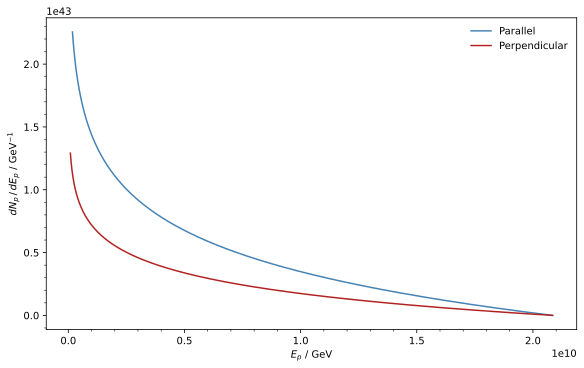

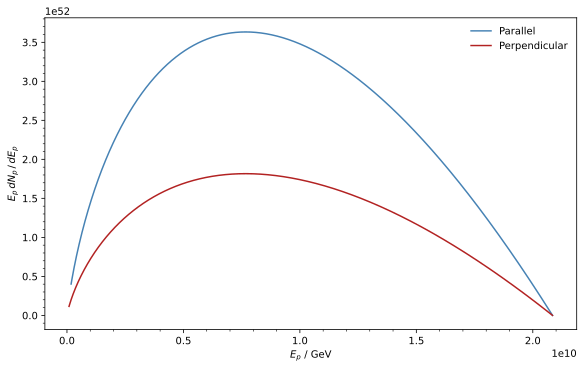

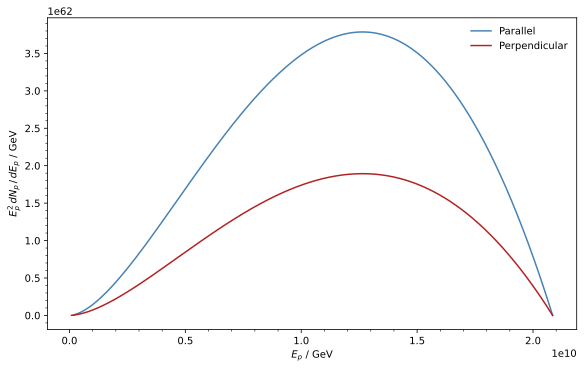

In [5]:
# plotting results
plt.plot([], [])
plt.plot(parallel_Ep[1:], parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$dN_p\,/\,dE_p$ / GeV$^{-1}$')
plt.legend()
plt.show()
plt.close()

plt.plot([], [])
plt.plot(parallel_Ep[1:], parallel_Ep[1:] * parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_Ep[1:] * perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p\,dN_p\,/\,dE_p$')
plt.legend()
plt.show()
plt.close()

plt.plot([], [])
plt.plot(parallel_Ep[1:], parallel_Ep[1:]**2 * parallel_dNdE, label='Parallel')
plt.plot(perpendicular_Ep[1:], perpendicular_Ep[1:]**2 * perpendicular_dNdE, label='Perpendicular')
plt.xlabel(r'$E_p$ / GeV')
plt.ylabel(r'$E_p^2\,dN_p\,/\,dE_p$ / GeV')
plt.legend()
plt.show()
plt.close()